<a href="https://colab.research.google.com/github/alvinadar/Simple-Time-Series-Forecasting-Using-RNN/blob/main/Lesson_65_1_Simple_RNN_for_time_series_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential#T o deal with sequential data
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split

#Create a simple dummy time series data

In [2]:
np.random.seed(42)
t = np.arange(0, 200, 0.5)                    # 400 points
series = np.sin(0.2 * t) + 0.5*np.sin(0.05*t) # base signal
series += 0.1 * np.random.randn(len(t))       # noise

In [5]:
series

array([ 4.96714153e-02,  9.85056845e-02,  2.88427769e-01,  4.85288046e-01,
        4.15919713e-01,  5.18349210e-01,  7.97282821e-01,  8.08015229e-01,
        7.69743318e-01,  9.49136095e-01,  9.18831195e-01,  9.80407853e-01,
        1.10399542e+00,  9.31884554e-01,  9.84406850e-01,  1.12440250e+00,
        1.09299966e+00,  1.22924993e+00,  1.10052799e+00,  1.03373894e+00,
        1.29557507e+00,  1.09123824e+00,  1.07659284e+00,  8.75147789e-01,
        9.03346145e-01,  9.02113040e-01,  7.02995217e-01,  7.77398340e-01,
        5.97033125e-01,  5.41647676e-01,  4.21768727e-01,  5.76666519e-01,
        2.98954180e-01,  1.03757104e-01,  2.02353592e-01, -8.90958416e-02,
       -2.99706290e-02, -3.26492772e-01, -3.37968743e-01, -2.54229092e-01,
       -2.62220345e-01, -3.73783188e-01, -4.49428988e-01, -5.06481231e-01,
       -6.53850593e-01, -5.98380741e-01, -5.83372911e-01, -4.32866116e-01,
       -4.95783237e-01, -6.88353709e-01, -4.52023568e-01, -4.86037753e-01,
       -4.69367763e-01, -

#Plot the dime series data

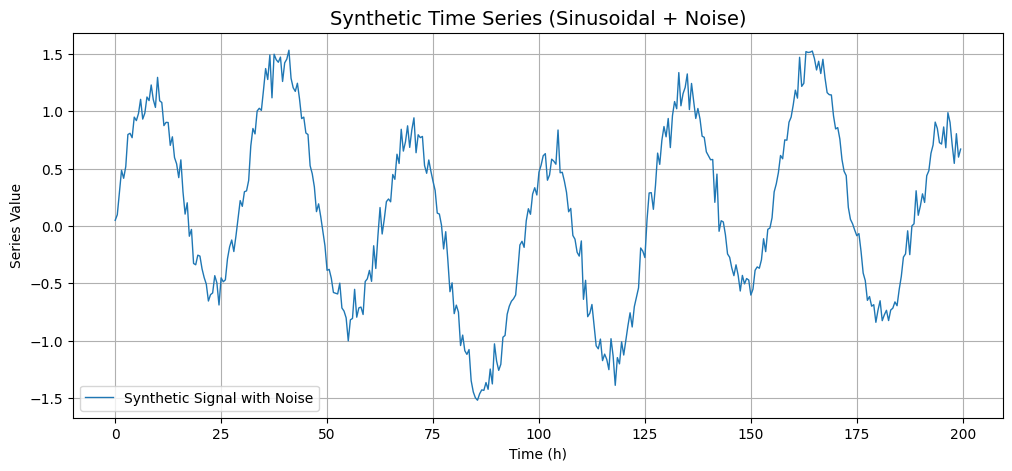

In [3]:
plt.figure(figsize=(12,5))
plt.plot(t,series,label = "Synthetic Signal with Noise",linewidth = 1)
plt.title("Synthetic Time Series (Sinusoidal + Noise)", fontsize=14)
plt.xlabel("Time (h)")
plt.ylabel("Series Value")
plt.legend()
plt.grid(True)
plt.show()

#Before we use this data , we need to scale it to 0-1 to help on the training and also remove bias in the data


* Once the data is scaled , it will work better when input are in a small and consistent range. 0 - 1 .
* Prevent large values from dominating gradient updates . (Bias).

##Example
Suppose your raw series ranges from -3.5 to +4.2.
* -3.5 -> 0
* 4.2 -> 1
* Everything else -> Propotionally between 0 - 1

In [4]:
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1,1)).flatten()
#converts your 1D array into a 2D column vector because scikit-learn expects input as (n_samples, n_features).
#fit_transform() learns the min and max of your data, then transforms each value.
#flatten() -> makes it 1D again so you can work with it like your original series.

#By now you should know that , RNN gets the input data in sequence .

* In this case we need to convert the continous series into (input-> output) sequence.

* Since its a supervised, we need to tune the data in a way that it shows the input sequence and the required output based on the sequential data.

* Normally this is done for timeseries or sequential data.

If series = [10, 20, 30, 40, 50] and window=3:

Iteration 0:

X[0] = [10, 20, 30]

y[0] = 40

Iteration 1:

X[1] = [20, 30, 40]

y[1] = 50

In [6]:
#arr -> your time series data (already scaled usually).
#win = 24 -> sliding window size (default = 24, often used for “last 24 hours” in hourly data).
def make_sequence(arr,win=24):
  X,y = [],[]#We create an empty list first for X to hold the input values , y to hold the target prediction.
  for i in range(len(arr)-win):
    X.append(arr[i:i+win]) # 0:24 -> [0,1,2,3,4,5,6,7,8,9,10...23]-> Input
    y.append(arr[i+win])#0+24 -> [24]-> Output
  X = np.array(X)[...,np.newaxis]#turns list of windows into 2D array (samples, win)-->[..., np.newaxis]-> adds a feature dimension → (samples, win, 1).
  y = np.array(y)
  return X,y

#Using the function created , we create the input features and the output labels with the time series data.

In [7]:
X,y = make_sequence(series_scaled)

In [16]:
len(X[0])#Mean you have 24 sequence of data

24

In [17]:
y

array([0.79387058, 0.79346639, 0.72819849, 0.75258674, 0.69346568,
       0.67531114, 0.63601659, 0.68678981, 0.59575979, 0.53177706,
       0.56409553, 0.4685627 , 0.48794307, 0.39074747, 0.38698582,
       0.41443445, 0.41181503, 0.37524637, 0.35045079, 0.33174991,
       0.2834444 , 0.3016266 , 0.30654594, 0.35587986, 0.33525655,
       0.27213478, 0.34960033, 0.33845098, 0.34391515, 0.40397849,
       0.4381747 , 0.45778841, 0.42484673, 0.46927869, 0.51903393,
       0.57033387, 0.55395418, 0.59569199, 0.59812469, 0.62795966,
       0.72642628, 0.77638767, 0.76090414, 0.82636883, 0.83411056,
       0.82817289, 0.88623162, 0.94761432, 0.91635179, 0.9864401 ,
       0.86402484, 0.98853799, 0.97298173, 0.96559167, 0.98033227,
       0.91074119, 0.96389072, 0.97466393, 1.        , 0.91999528,
       0.89286439, 0.88241363, 0.90565866, 0.86073077, 0.80463611,
       0.80887261, 0.76355591, 0.75902058, 0.67003037, 0.6472688 ,
       0.60964054, 0.53885158, 0.56103508, 0.52489271, 0.48233

In [ ]:
#Input -> [0,1,2,3,4]
#Ouput -> [5]

#Train validation split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # no shuffle for time-series
)

#Build the RNN Model

In [20]:
model = Sequential([
    SimpleRNN(32,input_shape = (24,1)),
    Dense(1)
])
#Sequential :  This line initializes a Sequential model, which means layers are added one after another in a linear stack.
#32 is the number of unit(neurons in this layer. This will deterimine the dimension of the output space of the layer
#input_shape = (24,1)-> Specifies the shape of the input data that the first layer expects.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#Compile the function

In [21]:
model.compile(optimizer ='adam',loss = 'mse')

Train the model

In [23]:
history = model.fit(X_train,y_train,epochs=20,batch_size=32,validation_data=(X_test,y_test),verbose=0)

#Validation data ->After each epoch, the model will evaluate itself on (X_test,y_test.)This will help you to monitor the overfitting.

In [25]:
history.history

{'loss': [0.001836551004089415,
  0.0019042325438931584,
  0.001876381691545248,
  0.002258346416056156,
  0.002205809112638235,
  0.0018779837992042303,
  0.0017060994869098067,
  0.0019021680345758796,
  0.001709149917587638,
  0.001911202329210937,
  0.001793176168575883,
  0.001796022872440517,
  0.0016740945866331458,
  0.0017895459895953536,
  0.002138475188985467,
  0.0016645562136545777,
  0.0016614575870335102,
  0.0016493957955390215,
  0.0021936227567493916,
  0.0016455997247248888],
 'val_loss': [0.002065493492409587,
  0.0018362775444984436,
  0.0021521574817597866,
  0.0019999402575194836,
  0.002529832301661372,
  0.0018308378057554364,
  0.0019270600751042366,
  0.0020310489926487207,
  0.0018449635244905949,
  0.0022399702575057745,
  0.0021153525449335575,
  0.0018444843590259552,
  0.0020443652756512165,
  0.0023699782323092222,
  0.0018797010416164994,
  0.0017946617444977164,
  0.0017871810123324394,
  0.0023045060224831104,
  0.0018068779027089477,
  0.00178175733

#Evaluate the model

In [26]:
print(f"Final val MSE: {history.history['val_loss'][-1]:.4f}")

Final val MSE: 0.0018


#Create the forcast from the last window

In [28]:
def forcast_multi(last_window_scaled,H):
  preds_scaled = []# store scaled predictions
  w = last_window_scaled.copy()# start with the last input window

  for _ in range(H):
    x = w.reshape(1,24,1)# shape: (batch=1, timesteps=24, features=1)
    next_scaled = float(model.predict(x,verbose=0)[0,0])
    preds_scaled.append(next_scaled)# save prediction into the empty array created
    w = np.append(w[1:],next_scaled) #slide window forward (drop oldest, add newest)
  preds = scaler.inverse_transform(
      np.array(preds_scaled).reshape(-1, 1)
    ).flatten()
  return preds

In [29]:
H = 50
last_window_scaled = X_test[-1].flatten()
future = forcast_multi(last_window_scaled,H)

In [30]:
future#Future predicted values

array([ 0.63250667,  0.54377304,  0.46927698,  0.37124022,  0.33521925,
        0.27813515,  0.20840659,  0.10310511, -0.00511954, -0.0838483 ,
       -0.12594765, -0.19238126, -0.27614164, -0.3666673 , -0.42835097,
       -0.49870315, -0.54171253, -0.56573775, -0.61817873, -0.66602688,
       -0.69867198, -0.70605471, -0.72959251, -0.72103891, -0.73031578,
       -0.72859266, -0.72115874, -0.70022763, -0.66991254, -0.63516055,
       -0.59896028, -0.56470126, -0.51584253, -0.45745636, -0.39454982,
       -0.32834514, -0.26046544, -0.19061114, -0.12080929, -0.03926055,
        0.04502161,  0.12300155,  0.19951768,  0.27307053,  0.34684722,
        0.41700838,  0.48755068,  0.54678905,  0.60022834,  0.64578484])

#Plot the values

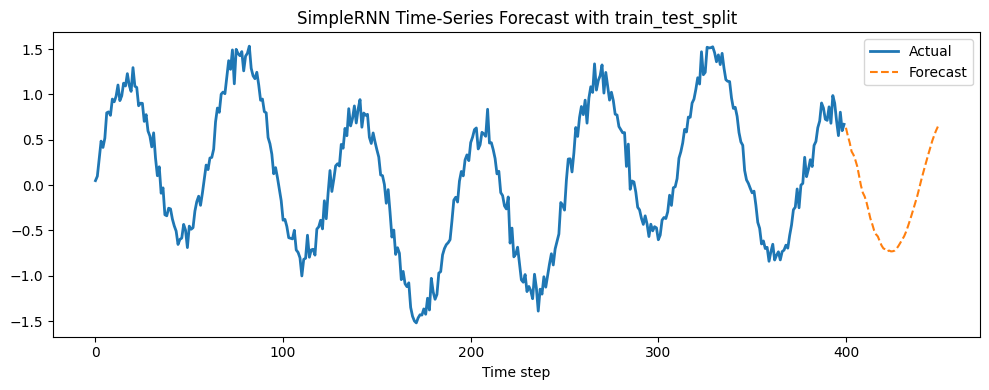

In [31]:
plt.figure(figsize=(10,4))
plt.plot(series, label="Actual", linewidth=2)
plt.plot(np.arange(len(series), len(series)+H), future, "--", label="Forecast")
plt.title("SimpleRNN Time-Series Forecast with train_test_split")
plt.xlabel("Time step")
plt.legend()
plt.tight_layout()
plt.show()